In [1]:
# Imports
import spacepy.time as spt
import spacepy.omni as om
from spacepy import coordinates as coord
import numpy as np
import tsygFort
import datetime as dt
from datetime import timedelta
import spacepy.datamodel as dm
import spacepy.toolbox as tb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

import sys
#sys.path.append('/Users/gfarinas/Documents/python_pack/test-particle/')
import testpartpy

######### For Debugging
import ipdb
import time

This unreleased version of SpacePy is not supported by the SpacePy team.
Qin-Denton/OMNI2 data not found in current format. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


# Times and Energy
The data I use to trace particles is from LANL. 

1)  The spacecraft coordinates are in GEO. The files are attached for each satellite. I will transform the position of spacecraft from GEO to GSM coordinates and send you the modified version soon.
2)  Date: 09 August 2015
3)  Time of arrival of every energy peak : (for different LANL satellites as given below)

Satellite: LANL 01 A
Energy (KeV)           :                  113 keV          170 keV             250 keV            400 keV   
Time of Arrival(HH:MM:SS):               05:42:52          05:41:43            05:41:18            05:40:47

Satellite: LANL 01 A
Energy (KeV)           :                  113 keV          170 keV             250 keV            400 keV   
Time of Arrival(HH:MM:SS):                05:48:10        05:47:22            05:46:12              05:44:19

Satellite: LANL 01 A
Energy (KeV)           :                  113 keV          170 keV             250 keV            400 keV   
Time of Arrival(HH:MM:SS):                06:04:12         06:02:52          06:02:19           06:01:31


Satellite: LANL 02 A
Energy (KeV)           :                  113 keV          170 keV             250 keV        400 keV   
Time of Arrival(HH:MM:SS):                06:10:27        06:07:16          06:04:44          06:02:58


Satellite:  LANL 04A 
Energy (KeV)           :                  170 keV             250 keV              350 keV
Time of Arrival(HH:MM:SS):                06:16:50            06:12:00              06:09:00

In [2]:
def get_loc(df,dtime):
    #dtime = dtime_loc
    #ipdb.set_trace()
    N = len(dtime)
    Re=6371
    for i in range(N):
        if dtime[i].second > 30:
            dtime_tmp = dtime[i]+timedelta(seconds=30) # get next minutes if seconds > 30
            geo = np.array(df.loc[(df[3] == dtime_tmp.hour) & (df[4] == dtime_tmp.minute) , 6:8])/Re
            if geo.size == 0:
                #dtime_tmp = dtime[i]-timedelta(seconds=30) # if next min is not present take the original
                geo = np.array(df.loc[(df[3] == dtime[i].hour) & (df[4] == dtime[i].minute) , 6:8])/Re
        else:
            geo = np.array(df.loc[(df[3] == dtime[i].hour) & (df[4] == dtime[i].minute) , 6:8])/Re
            if geo.size == 0:
                dtime_tmp = dtime[i]+timedelta(seconds=60) # go to next min if not present
                geo = np.array(df.loc[(df[3] == dtime_tmp.hour) & (df[4] == dtime_tmp.minute) , 6:8])/Re
        #ipdb.set_trace()
        cvals = coord.Coords(geo, 'GEO', 'car',)
        cvals.ticks = spt.Ticktock(dtime[i], 'ISO') # add ticks
        if i == 0:
            gsm_tmp = cvals.convert('GSM', 'car')
            gsm_arr = coord.Coords(gsm_tmp.data, 'GSM', 'car')
        else:
            gsm_tmp = cvals.convert('GSM', 'car')
            gsm_arr = gsm_arr.append(gsm_tmp)
    return gsm_arr
def trace_FL(tsc,loc,axis,proj='xy'):
        dts = spt.Ticktock(tsc)
        year = tsc.year
        doy = dts.DOY
        hr = tsc.hour
        mn = tsc.minute
        sc = tsc.second
        lmax = 5000
        rlim = 60. 
        r0 = 1. 
        dsmax = .5
        err = .000001
        omni_data = om.get_omni(tsc,dbase='qd5min')
        vxgse = omni_data['Vsw']
        vygse = 0.
        vzgse = 0.
        parmod = np.zeros(10)
        parmod[0:4] = [omni_data['Pdyn'], omni_data['Dst'], omni_data['ByIMF'], omni_data['BzIMF']]
        parmod[4:10]=omni_data['W']
        tsygFort.recalc_08(year,doy,hr,mn,sc,vxgse,vygse,vzgse)
        # Trace field line
        mapto = 1 # Direction of the tracing
        exname = 'T04_s'
        xfgsm,yfgsm,zfgsm,xarr,yarr,zarr,l = tsygFort.trace_08(loc[0],loc[1],loc[2],mapto,dsmax,err, \
                                            rlim,r0,0,parmod,exname,'IGRF_GSW_08',lmax)
        mapto = -1 # Direction of the tracing
        xfgsm1,yfgsm1,zfgsm1,xarr1,yarr1,zarr1,l1 = tsygFort.trace_08(loc[0],loc[1],loc[2],mapto,dsmax,err, 
                                            rlim,r0,0,parmod,exname,'IGRF_GSW_08',lmax)
        xgsm = np.concatenate((np.flipud(xarr1[0:l1]),xarr[0:l]),axis=0)
        ygsm = np.concatenate((np.flipud(yarr1[0:l1]),yarr[0:l]),axis=0)
        zgsm = np.concatenate((np.flipud(zarr1[0:l1]),zarr[0:l]),axis=0)
        if proj == 'xy':
            axis.plot(xgsm,ygsm,color='k',zorder=0)
        elif proj == 'xz':
            axis.plot(xgsm,zgsm,color='k',zorder=0)
        elif proj == 'yz':
            axis.plot(ygsm,zgsm,color='k',zorder=0)
        else:
            print('proj should be xy,xz or yz')
        return 1        

In [3]:
date=dt.datetime(2015,8,9)
fephe_01A = './20150809_LANL-01A_EPHEM_pos.dat'
fephe_02A = './20150809_LANL-02A_EPHEM_pos.dat'
fephe_04A = './20150809_LANL-04A_EPHEM_pos.dat'
ephe_01A = pd.read_csv(fephe_01A,sep='\s+',header=-1)# read data from file
ephe_02A = pd.read_csv(fephe_02A,sep='\s+',header=-1)# read data from file
ephe_04A = pd.read_csv(fephe_04A,sep='\s+',header=-1)# read data from file
LANL_01A_tinj1 = [dt.datetime(2015,8,9,5,42,52),dt.datetime(2015,8,9,5,41,43),dt.datetime(2015,8,9,5,41,18),dt.datetime(2015,8,9,5,40,47)]
LANL_01A_tinj2 = [dt.datetime(2015,8,9,5,48,10),dt.datetime(2015,8,9,5,47,22),dt.datetime(2015,8,9,5,46,12),dt.datetime(2015,8,9,5,44,19)]
LANL_01A_tinj3 = [dt.datetime(2015,8,9,6,4,12),dt.datetime(2015,8,9,6,2,52),dt.datetime(2015,8,9,6,2,19),dt.datetime(2015,8,9,6,1,31)]
LANL_02A_t = [dt.datetime(2015,8,9,6,10,27),dt.datetime(2015,8,9,6,7,16),dt.datetime(2015,8,9,6,4,44),dt.datetime(2015,8,9,6,2,58)]
LANL_04A_t = [dt.datetime(2015,8,9,6,16,50),dt.datetime(2015,8,9,6,12,0),dt.datetime(2015,8,9,6,9,0)]
LANL_01A_Ech = [113,          170,             250,            400 ]
LANL_02A_Ech = [113,          170,             250,            400 ]
LANL_04A_Ech = [170,          250,             400 ]
LANL_01A_inj1_gsm = get_loc(ephe_01A,LANL_01A_tinj1)
LANL_01A_inj2_gsm = get_loc(ephe_01A,LANL_01A_tinj2)
LANL_01A_inj3_gsm = get_loc(ephe_01A,LANL_01A_tinj3)
LANL_02A_gsm = get_loc(ephe_02A,LANL_02A_t)
LANL_04A_gsm = get_loc(ephe_04A,LANL_04A_t)

In [4]:
#### Position of the satellites
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(20,10))
gsm_01A = LANL_01A_inj3_gsm[0]
gsm_02A = LANL_02A_gsm[0]
gsm_04A = LANL_04A_gsm[0]
tinj_init = LANL_01A_tinj2[0]
# Plot X,Y
ax = fig.add_subplot(121)
circle=plt.Circle((0,0),1)
ax.add_artist(circle)
ax.set_aspect('equal')
ax.scatter(gsm_01A.x,gsm_01A.y,s=200,label='LANL-01A')
ax.scatter(gsm_02A.x,gsm_02A.y,s=200,label='LANL-02A')
ax.scatter(gsm_04A.x,gsm_04A.y,s=200,label='LANL-04A')
ax.annotate('LANL-01A', (gsm_01A.x+1.7,gsm_01A.y-.4),fontsize = 15)
ax.annotate('LANL-02A', (gsm_02A.x-.5,gsm_02A.y+.5),fontsize = 15)
ax.annotate('LANL-04A', (gsm_04A.x,gsm_04A.y+1),fontsize = 15)
#ax.legend()
ax.set_ylabel('$Y_{GSM}$',fontsize = 20);
ax.set_xlabel('$X_{GSM}$',fontsize = 20);
#ax.set_xlim([-6,6]);
ax.invert_xaxis()
ax.invert_yaxis()
trace_FL(tinj_init,gsm_01A.data[0],ax,proj='xy')
trace_FL(tinj_init,gsm_02A.data[0],ax,proj='xy')
trace_FL(tinj_init,gsm_04A.data[0],ax,proj='xy')
# Plot X,Z
ax = fig.add_subplot(122)
circle=plt.Circle((0,0),1)
ax.add_artist(circle)
ax.set_aspect('equal')
ax.scatter(gsm_01A.x,gsm_01A.z,s=200,label='LANL-01A')
ax.scatter(gsm_02A.x,gsm_02A.z,s=200,label='LANL-02A')
ax.scatter(gsm_04A.x,gsm_04A.z,s=200,label='LANL-04A')
ax.annotate('LANL-01A', (gsm_01A.x+.5,gsm_01A.z+.5),fontsize = 15)
ax.annotate('LANL-02A', (gsm_02A.x,gsm_02A.z+.5),fontsize = 15)
ax.annotate('LANL-04A', (gsm_04A.x+.5,gsm_04A.z+.5),fontsize = 15)
trace_FL(tinj_init,gsm_01A.data[0],ax,proj='xz')
trace_FL(tinj_init,gsm_02A.data[0],ax,proj='xz')
trace_FL(tinj_init,gsm_04A.data[0],ax,proj='xz')
#ax.legend()
ax.set_ylabel('$Z_{GSM}$',fontsize = 20);
ax.set_xlabel('$X_{GSM}$',fontsize = 20);
ax.invert_xaxis()
ax.set_ylim([-4,4]);
### Saving picture
fig.savefig('LANL_20150809_SC_GSM_loc.png', dpi = 200)


OSError: Specified dbase (qd5min) must be specified in spacepy.config

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff3e83b31e0> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: 'dvipng': 'dvipng'

FileNotFoundError: [Errno 2] No such file or directory: 'dvipng': 'dvipng'

<Figure size 1440x720 with 1 Axes>

# LANL-01A injection 1

In [8]:
# Input parameters
# 1- Date and time of the injection
#-----------------------------------------------------------------------------------#
imod = 0        # magnetic field model: 0=dipole, 1=T96_01, 2=T01_01, 3=T04_s
ipot = 1        # electric field model: 1=Weimer, 2=CIMI 
itrace = -1      # 1=forward, -1=backward tracing
ion= 1          # 1=ion, -1=electron
tf =1
dmin=dt.datetime(2015,8,9,5,38,30)
sim_dt = np.zeros(len(LANL_01A_Ech))
for i in range(len(LANL_01A_Ech)):
    sim_dt[i] = (LANL_01A_tinj1[i]-dmin).total_seconds() # simulation time in seconds
LANL_01A_inj1_gsm.ticks = spt.Ticktock(LANL_01A_tinj1, 'ISO') #
LANL_01A_inj1_sm = LANL_01A_inj1_gsm.convert('SM', 'car') # SM coordinates
PA = 90
sinA_loc = np.sin(PA/180*np.pi)
### Define class

part=testpartpy.avedrift(date,itrace=itrace,imod=imod,tf=1)
tsec = []
mlto = []
ro = []
Eo = []

for i in range(len(LANL_01A_Ech)):
    tsecarr,mltoarr,roarr,Eoarr,pitchA,istep = part.trace_drift_shell(LANL_01A_inj1_sm[i].data[0],\
                                        LANL_01A_tinj1[i],LANL_01A_Ech[i],sinA_loc,sim_dt[i])
    tsec.append(tsecarr)
    mlto.append(mltoarr)
    ro.append(roarr)
    Eo.append(Eoarr)

/Users/gfarinas/anaconda3/envs/spacepy_env/lib/python3.6/site-packages/spacepy/datamodel.py:1468: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)
/Users/gfarinas/Documents/python_pack/test-particle/testpartpy.py:643: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(istep,dstep)==0:


Variable OriginFile appears to be non-record varying, skipping interpolation
Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 0 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     mlto     ekeV    PA   Vsw   Pdyn
2015-08-09T05:42:52      -9     6.637    18.554      6.617 18.554   113.0  90.00
2015-08-09T05:42:47.364492      -9     6.635    18.588      6.635 18.588   113.1  90.00  505.77 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:42.733039      -9     6.633    18.621      6.633 18.621   113.2  90.00  505.75 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:38.097381      -9     6.631    18.654      6.631 18.654   113.3  90.00  505.72 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:33.476526      -9     6.628    18.688      6.628 

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:27.357446     -10     6.563    20.054      6.562 20.054   116.9  90.00  504.64 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:22.892386     -10     6.562    20.088      6.563 20.088   116.8  90.00  504.62 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:18.407117     -10     6.562    20.121      6.561 20.121   116.9  90.00  504.59 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:13.907197     -10     6.560    20.154      6.559 20.154   117.0  90.00  504.56 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:09.413706     -10     6.560    20.188      6.560 20.188   117.0  90.00  504.54 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:04.947

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:08.067235     -10     6.602    19.569      6.602 19.569   172.6  90.00  504.86 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:05.030100     -10     6.601    19.602      6.601 19.602   172.7  90.00  504.85 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:01.995053     -10     6.601    19.636      6.600 19.636   172.7  90.00  504.83 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:58.966820     -10     6.600    19.669      6.600 19.669   172.8  90.00  504.81 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:55.933416     -10     6.599    19.702      6.599 19.702   172.8  90.00  504.79 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:52.898

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:52.783020     -10     6.627    18.929      6.627 18.929   251.1  90.00  505.11 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:50.691357     -10     6.625    18.962      6.626 18.962   251.3  90.00  505.10 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:48.598796     -10     6.624    18.996      6.625 18.996   251.4  90.00  505.09 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:46.504121     -10     6.625    19.029      6.625 19.029   251.3  90.00  505.08 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:44.404838     -10     6.624    19.062      6.624 19.062   251.4  90.00  505.06 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:42.320

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:08.492287     -10     6.609    20.596      6.608 20.596   253.2  90.00  504.52 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:06.404944     -10     6.609    20.629      6.608 20.629   253.3  90.00  504.51 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:04.319942     -10     6.608    20.662      6.607 20.662   253.4  90.00  504.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:02.234944     -10     6.608    20.696      6.608 20.696   253.3  90.00  504.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:00.146150     -10     6.608    20.729      6.607 20.729   253.4  90.00  504.47 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:38:58.058

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:08.922213     -10     6.612    19.487      6.611 19.487   404.6  90.00  504.86 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:07.614628     -10     6.612    19.521      6.612 19.521   404.3  90.00  504.85 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:06.307596     -10     6.611    19.554      6.610 19.554   404.7  90.00  504.84 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:04.997374     -10     6.610    19.587      6.610 19.587   404.8  90.00  504.84 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:03.693577     -10     6.609    19.621      6.609 19.621   405.0  90.00  504.83 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:40:02.387

Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:05.011780     -10     6.597    21.121      6.597 21.121   407.2  90.00  504.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:03.710572     -10     6.596    21.154      6.595 21.154   407.4  90.00  504.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:02.402291     -10     6.597    21.187      6.597 21.187   407.2  90.00  504.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:39:01.100277     -10     6.597    21.221      6.596 21.221   407.3  90.00  504.47 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:38:59.792975     -10     6.598    21.254      6.597 21.254   407.2  90.00  504.47 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:38:58.485

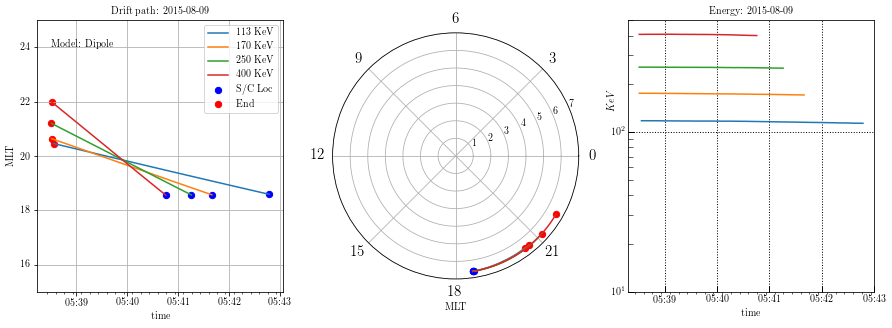

In [7]:
###########################################################
##### Visualize the data
###########################################################
datet = dt.datetime(2015,8,9)
date = dt.date(2015,8,9)
iyear = datet.year
dts = spt.Ticktock(datet)
iday = dts.DOY
%matplotlib inline
minuts = mdates.MinuteLocator()  # every min
secticks = mdates.SecondLocator(interval=10)  # every sec
Fmt = mdates.DateFormatter('%H:%M')
#plt.style.use('classic')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
# Create a new figure
fig = plt.figure("pyplot_fig",figsize=(15,5))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,polar=True)
ax3 = plt.subplot(133)
ekev0 = LANL_01A_Ech   ### Change this for other LANL, i.e LANL-02A
xstart = np.zeros(len(ekev0))
ystart = np.zeros(len(ekev0))
xend = np.zeros(len(ekev0))
yend = np.zeros(len(ekev0))
ii=0
xstart = []
xend = []
model = ['Dipole', 'T96', 'T01', 'TS04']
for i in ekev0:
    #First subplot
    #plt.subplot(131)
    nt=len(tsec[ii])
    t_utc = np.zeros(len(tsec[ii]))
    for j in range(len(tsec[ii])):
        t_utc[j] = (tsec[ii][j]-datet).total_seconds()/60
    #ax1.plot(df.tsec, df.mlto,label=str(i))
    #ax1.plot(t_utc, mlto[ii][0:nt],label=str(i))
    ax1.plot(tsec[ii], mlto[ii][0:nt],label=str(i)+' KeV')
    #xstart[ii]=t_utc[0]
    xstart.append(tsec[ii][0])
    ystart[ii]=mlto[ii][0]
    #xend[ii]=t_utc[-1]
    xend.append(tsec[ii][-1])
    yend[ii]=mlto[ii][nt-1]
    #Second subplot
    #plt.subplot(132,polar=True)
    rad = np.ones(nt)
    for j in range(nt):
        rad[j] = np.pi*mlto[ii][j]/12
    print, rad
    ax2.plot(rad, ro[ii][0:nt])
    ax2.scatter(rad[0],ro[ii][0],color='b',s=40,label='LANL-01A')
    #ax2.text(rad[0]+0.1, df.ro[0], 'Start', fontsize=15, color='k')
    ax2.scatter(rad[nt-1],ro[ii][nt-1],color='r',s=40,label='End backward tracing')
    #ax2.text(rad[-1]-0.1, df['ro'].iloc[-1]-0.1, 'End', fontsize=15, color='k')
    #Energy subplot
    ax3.plot(tsec[ii], Eo[ii][0:nt])
    ii=ii+1
# Plot Start and End points
ax1.scatter(xstart,ystart,color='b',s=40,label='S/C Loc')
ax1.scatter(xend,yend,color='r',s=40,label='End')
ax1.set_ylabel('MLT')
ax1.set_xlabel('time')
ax1.set_title('Drift path: '+ date.isoformat(),fontsize = 10)
#ax1.set_xlim(xmin=dt.datetime(2015,8,9,5,38,30),xmax=dt.datetime(2015,8,9,5,43))
ax1.set_ylim(ymin=15,ymax=25)
ax1.legend(loc=1,scatterpoints=1)
ax1.grid(b=True)
ax1.text(dmin, 24, 'Model: '+ model[imod], fontsize=10)
# format the ticks
ax1.xaxis.set_major_locator(minuts)
ax1.xaxis.set_major_formatter(Fmt)
ax1.xaxis.set_minor_locator(secticks)
#Second subplot
ax2.axis([0, 2*np.pi, 0, 7])
ax2.set_xticklabels(['0','3','6','9','12','15','18','21'],fontsize = 15)
ax2.set_xlabel('MLT');
#Energy subplot
ax3.set_yscale("log", nonposy='clip')
ax3.set_ylim(ymin=10,ymax=500)
ax3.set_ylabel(r'$KeV$')
ax3.yaxis.set_label_coords(-0.05,0.7)
ax3.set_xlabel('time')
ax3.set_title('Energy: '+date.isoformat(),fontsize = 10);
ax3.grid(b='True',color='k', linestyle=':', linewidth=1)
ax3.tick_params(direction='in', length=6, width=1, colors='k')
ax3.tick_params(axis='y',which='minor',direction='in', length=5, width=0.6, colors='k')
ax3.xaxis.set_major_locator(minuts)
ax3.xaxis.set_major_formatter(Fmt)
ax3.xaxis.set_minor_locator(secticks)
#plt.grid(b='off') #No grid

#text(8.57, 0, r'\textbf{1}', fontsize=25, color='w')

### Saving picture
fig.savefig('LANL-01A_'+'inj1'+str(PA)+'PAdegrees_'+model[imod]+'.png', dpi = 200) # Change this name for every injection

# LANL-01A injection 2

In [9]:
# Input parameters
# 1- Date and time of the injection
#-----------------------------------------------------------------------------------#
imod = 3        # magnetic field model: 0=dipole, 1=T96_01, 2=T01_01, 3=T04_s
ipot = 1        # electric field model: 1=Weimer, 2=CIMI 
itrace = -1      # 1=forward, -1=backward tracing
ion= 1          # 1=ion, -1=electron
tf =1
dmin=dt.datetime(2015,8,9,5,41,30)
sim_dt = np.zeros(len(LANL_01A_Ech))
for i in range(len(LANL_01A_Ech)):
    sim_dt[i] = (LANL_01A_tinj2[i]-dmin).total_seconds() # simulation time in seconds
LANL_01A_inj2_gsm.ticks = spt.Ticktock(LANL_01A_tinj2, 'ISO') #
LANL_01A_inj2_sm = LANL_01A_inj2_gsm.convert('SM', 'car') # SM coordinates
sinA_loc = np.sin(90/180*np.pi)
### Define class

part=testpartpy.avedrift(date,itrace=itrace,imod=imod,tf=1)
tsec = []
mlto = []
ro = []
Eo = []
pitchA = []
for i in range(len(LANL_01A_Ech)):
    tsecarr,mltoarr,roarr,Eoarr,pitchA,istep = part.trace_drift_shell(LANL_01A_inj2_sm[i].data[0],\
                                        LANL_01A_tinj2[i],LANL_01A_Ech[i],sinA_loc,sim_dt[i])
    tsec.append(tsecarr)
    mlto.append(mltoarr)
    ro.append(roarr)
    Eo.append(Eoarr)

/Users/gfarinas/anaconda3/envs/spacepy_env/lib/python3.6/site-packages/spacepy/datamodel.py:1468: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)


Variable OriginFile appears to be non-record varying, skipping interpolation
Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 3 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     mlto     ekeV    PA   Vsw   Pdyn
2015-08-09T05:48:10      -9     5.587    18.579      6.618 18.641   113.0  79.23
2015-08-09T05:48:04.174223      -9     5.575    18.613      6.642 18.674   113.1  79.31  507.58 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation


/Users/gfarinas/Documents/python_pack/test-particle/testpartpy.py:643: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(istep,dstep)==0:


2015-08-09T05:47:58.445102      -9     5.566    18.646      6.634 18.707   113.0  79.41  507.54 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:47:52.809141      -9     5.555    18.679      6.621 18.740   113.3  79.27  507.51 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:47:47.232048      -9     5.545    18.712      6.612 18.772   113.2  79.30  507.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:47:41.690784      -9     5.536    18.746      6.604 18.805   113.3  79.19  507.45 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:47:36.235429      -9     5.526    18.779      6.593 18.838   113.3  79.28  507.42 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:47:30.806261      -9     5.518    18.812      6.587 18.870   113.3  79.24  507.39 2.81

2015-08-09T05:44:28.804567      -9     5.246    20.178      6.298 20.209   116.1  78.24  506.34 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:44:25.103560      -9     5.242    20.211      6.292 20.242   116.0  78.37  506.32 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:44:21.421229      -9     5.236    20.245      6.285 20.274   116.2  78.35  506.30 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:44:17.773165      -9     5.234    20.278      6.283 20.307   116.1  78.29  506.28 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:44:14.136668      -9     5.230    20.311      6.279 20.340   116.1  78.29  506.26 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:44:10.542244      -9     5.225    20.345      6.272 20.372   116.3  78.22  506.24 2.81

2015-08-09T05:41:56.158146     -10     5.130    21.711      6.146 21.719   117.3  77.58  505.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:53.108850     -10     5.129    21.745      6.142 21.752   117.4  77.56  505.46 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:50.047371     -10     5.128    21.778      6.141 21.785   117.5  77.51  505.44 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:46.996516     -10     5.128    21.811      6.142 21.818   117.2  77.58  505.42 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:43.954902     -10     5.128    21.845      6.140 21.851   117.3  77.48  505.41 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:40.885562     -10     5.127    21.878      6.140 21.884   117.2  77.53  505.39 2.81

2015-08-09T05:45:28.321845      -9     5.319    19.732      6.384 19.772   172.5  78.64  506.68 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:25.598546      -9     5.313    19.765      6.377 19.804   172.8  78.49  506.66 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:22.888820      -9     5.308    19.798      6.371 19.837   172.8  78.56  506.65 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:20.220742      -9     5.303    19.832      6.366 19.870   172.7  78.56  506.63 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:17.567711      -9     5.297    19.865      6.359 19.902   173.0  78.46  506.61 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:14.937422      -9     5.292    19.898      6.353 19.935   173.1  78.43  506.60 2.81

2015-08-09T05:43:38.912725      -9     5.154    21.265      6.186 21.277   175.3  77.82  506.05 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:36.780152      -9     5.153    21.298      6.185 21.310   175.4  77.72  506.04 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:34.656093      -9     5.153    21.331      6.184 21.343   175.0  77.88  506.03 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:32.541580      -9     5.151    21.365      6.181 21.376   175.2  77.77  506.02 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:30.440618      -9     5.149    21.398      6.180 21.409   175.1  77.80  506.00 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:28.331127      -9     5.148    21.431      6.177 21.442   175.0  77.84  505.99 2.81

2015-08-09T05:42:05.146659     -10     5.140    22.798      6.136 22.800   174.0  77.38  505.52 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:03.155294     -10     5.141    22.831      6.137 22.834   174.0  77.26  505.51 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:01.165632     -10     5.141    22.865      6.135 22.867   174.1  77.30  505.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:59.175345     -10     5.141    22.898      6.134 22.900   174.2  77.28  505.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:57.189143     -10     5.142    22.931      6.134 22.934   174.1  77.34  505.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:55.187217     -10     5.143    22.965      6.133 22.967   174.2  77.34  505.46 2.81

2015-08-09T05:45:12.111124      -9     5.381    19.414      6.453 19.460   251.6  78.73  506.58 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:10.084914      -9     5.375    19.447      6.447 19.492   251.7  78.72  506.57 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:08.072560      -9     5.369    19.480      6.443 19.525   251.6  78.67  506.56 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:06.072587      -9     5.363    19.514      6.436 19.558   251.7  78.63  506.55 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:04.097615      -9     5.357    19.547      6.430 19.590   251.9  78.57  506.53 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:45:02.142977      -9     5.351    19.580      6.424 19.623   251.7  78.67  506.52 2.81

2015-08-09T05:43:52.204875      -9     5.187    20.947      6.242 20.964   253.8  77.87  506.12 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:50.683370      -9     5.184    20.980      6.237 20.997   254.1  77.81  506.12 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:49.162309      -9     5.182    21.013      6.234 21.030   254.0  77.85  506.11 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:47.643716      -9     5.181    21.047      6.233 21.062   253.9  77.82  506.10 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:46.133101      -9     5.177    21.080      6.227 21.095   254.4  77.73  506.09 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:44.633821      -9     5.176    21.113      6.226 21.128   253.9  77.81  506.08 2.81

2015-08-09T05:42:46.336881      -9     5.143    22.480      6.154 22.482   254.4  77.20  505.75 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:44.959523      -9     5.143    22.513      6.154 22.515   254.2  77.29  505.74 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:43.597342      -9     5.144    22.547      6.154 22.549   254.1  77.25  505.73 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:42.226662      -9     5.144    22.580      6.154 22.582   254.1  77.18  505.73 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:40.864383      -9     5.144    22.613      6.152 22.615   254.1  77.28  505.72 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:39.501695      -9     5.146    22.647      6.155 22.649   253.9  77.17  505.71 2.81

2015-08-09T05:41:43.664340     -10     5.191     0.013      6.170  0.022   252.5  77.43  505.40 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:42.287363     -10     5.196     0.046      6.176  0.056   251.9  77.34  505.39 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:40.914315     -10     5.200     0.080      6.182  0.089   251.9  77.07  505.38 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:39.520541     -10     5.202     0.113      6.183  0.123   251.5  77.21  505.37 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:38.137317     -10     5.204     0.146      6.185  0.157   251.5  77.22  505.36 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:36.748184     -10     5.205     0.180      6.184  0.190   251.6  77.31  505.36 2.81

2015-08-09T05:43:31.375632      -9     5.339    19.650      6.414 19.692   401.1  79.01  506.00 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:30.169790      -9     5.335    19.683      6.411 19.724   400.9  78.93  506.00 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:28.980405      -9     5.330    19.716      6.406 19.757   400.7  78.95  505.99 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:27.805268      -9     5.323    19.750      6.399 19.790   401.4  78.82  505.98 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:26.632997      -9     5.319    19.783      6.394 19.822   401.1  78.88  505.98 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:43:25.469353      -9     5.311    19.816      6.385 19.855   401.7  78.93  505.97 2.81

2015-08-09T05:42:43.244088      -9     5.177    21.183      6.232 21.197   402.5  78.17  505.73 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:42.303694      -9     5.176    21.216      6.233 21.230   401.8  78.18  505.73 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:41.365462      -9     5.176    21.249      6.233 21.263   401.7  78.03  505.72 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:40.430870      -9     5.174    21.283      6.231 21.296   401.2  78.14  505.71 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:39.495903      -9     5.172    21.316      6.227 21.329   401.5  78.13  505.71 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:38.565242      -9     5.169    21.349      6.222 21.362   401.9  78.14  505.70 2.81

2015-08-09T05:42:02.322528     -10     5.152    22.716      6.167 22.719   401.6  77.60  505.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:01.456745     -10     5.154    22.749      6.169 22.752   400.8  77.62  505.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:42:00.596159     -10     5.154    22.783      6.168 22.785   400.4  77.83  505.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:59.740386     -10     5.154    22.816      6.166 22.819   401.1  77.71  505.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:58.883501     -10     5.155    22.849      6.166 22.852   400.9  77.77  505.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:41:58.021850     -10     5.156    22.883      6.166 22.885   401.1  77.65  505.47 2.81

In [ ]:
###########################################################
##### Visualize the data
###########################################################
datet = dt.datetime(2015,8,9)
date = dt.date(2015,8,9)
iyear = datet.year
dts = spt.Ticktock(datet)
iday = dts.DOY
%matplotlib inline
minuts = mdates.MinuteLocator()  # every min
secticks = mdates.SecondLocator(interval=10)  # every sec
Fmt = mdates.DateFormatter('%H:%M')
#plt.style.use('classic')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
# Create a new figure
fig = plt.figure("pyplot_fig",figsize=(15,5))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,polar=True)
ax3 = plt.subplot(133)
ekev0 = LANL_01A_Ech   ### Change this for other LANL, i.e LANL-02A
xstart = np.zeros(len(ekev0))
ystart = np.zeros(len(ekev0))
xend = np.zeros(len(ekev0))
yend = np.zeros(len(ekev0))
ii=0
xstart = []
xend = []
for i in ekev0:
    #First subplot
    #plt.subplot(131)
    nt=len(tsec[ii])
    t_utc = np.zeros(len(tsec[ii]))
    for j in range(len(tsec[ii])):
        t_utc[j] = (tsec[ii][j]-datet).total_seconds()/60
    #ax1.plot(df.tsec, df.mlto,label=str(i))
    #ax1.plot(t_utc, mlto[ii][0:nt],label=str(i))
    ax1.plot(tsec[ii], mlto[ii][0:nt],label=str(i)+' KeV')
    #xstart[ii]=t_utc[0]
    xstart.append(tsec[ii][0])
    ystart[ii]=mlto[ii][0]
    #xend[ii]=t_utc[-1]
    xend.append(tsec[ii][-1])
    yend[ii]=mlto[ii][nt-1]
    #Second subplot
    #plt.subplot(132,polar=True)
    rad = np.ones(nt)
    for j in range(nt):
        rad[j] = np.pi*mlto[ii][j]/12
    print, rad
    ax2.plot(rad, ro[ii][0:nt])
    ax2.scatter(rad[0],ro[ii][0],color='b',s=40,label='LANL-01A')
    #ax2.text(rad[0]+0.1, df.ro[0], 'Start', fontsize=15, color='k')
    ax2.scatter(rad[nt-1],ro[ii][nt-1],color='r',s=40,label='End backward tracing')
    #ax2.text(rad[-1]-0.1, df['ro'].iloc[-1]-0.1, 'End', fontsize=15, color='k')
    #Energy subplot
    ax3.plot(tsec[ii], Eo[ii][0:nt])
    ii=ii+1
# Plot Start and End points
ax1.scatter(xstart,ystart,color='b',s=40,label='S/C Loc')
ax1.scatter(xend,yend,color='r',s=40,label='End')
ax1.set_ylabel('MLT')
ax1.set_xlabel('time')
ax1.set_title('Drift path: '+ date.isoformat(),fontsize = 10)
#ax1.set_xlim(xmin=dt.datetime(2015,8,9,5,38,30),xmax=dt.datetime(2015,8,9,5,43))
ax1.set_ylim(ymin=15,ymax=25)
ax1.legend(loc=1,scatterpoints=1)
ax1.grid(b=True)
ax1.text(dmin, 24, 'Model TS04', fontsize=10)
# format the ticks
ax1.xaxis.set_major_locator(minuts)
ax1.xaxis.set_major_formatter(Fmt)
ax1.xaxis.set_minor_locator(secticks)
#Second subplot
ax2.axis([0, 2*np.pi, 0, 7])
ax2.set_xticklabels(['0','3','6','9','12','15','18','21'],fontsize = 15)
ax2.set_xlabel('MLT');
#Energy subplot
ax3.set_yscale("log", nonposy='clip')
ax3.set_ylim(ymin=10,ymax=500)
ax3.set_ylabel(r'$KeV$')
ax3.yaxis.set_label_coords(-0.05,0.7)
ax3.set_xlabel('time')
ax3.set_title('Energy: '+date.isoformat(),fontsize = 10);
ax3.grid(b='True',color='k', linestyle=':', linewidth=1)
ax3.tick_params(direction='in', length=6, width=1, colors='k')
ax3.tick_params(axis='y',which='minor',direction='in', length=5, width=0.6, colors='k')
ax3.xaxis.set_major_locator(minuts)
ax3.xaxis.set_major_formatter(Fmt)
ax3.xaxis.set_minor_locator(secticks)
#plt.grid(b='off') #No grid

#text(8.57, 0, r'\textbf{1}', fontsize=25, color='w')

### Saving picture
fig.savefig('LANL-01A_'+'inj2'+'.png', dpi = 200)

# LANL-01A injection 3

In [10]:
# Input parameters
# 1- Date and time of the injection
#-----------------------------------------------------------------------------------#
imod = 3        # magnetic field model: 0=dipole, 1=T96_01, 2=T01_01, 3=T04_s
ipot = 1        # electric field model: 1=Weimer, 2=CIMI 
itrace = -1      # 1=forward, -1=backward tracing
ion= 1          # 1=ion, -1=electron
tf =1
dmin=dt.datetime(2015,8,9,5,58,55)
sim_dt = np.zeros(len(LANL_01A_Ech))
for i in range(len(LANL_01A_Ech)):
    sim_dt[i] = (LANL_01A_tinj3[i]-dmin).total_seconds() # simulation time in seconds
LANL_01A_inj3_gsm.ticks = spt.Ticktock(LANL_01A_tinj3, 'ISO') #
LANL_01A_inj3_sm = LANL_01A_inj3_gsm.convert('SM', 'car') # SM coordinates
sinA_loc = np.sin(90/180*np.pi)
### Define class

part=testpartpy.avedrift(date,itrace=itrace,imod=imod,tf=1)
tsec = []
mlto = []
ro = []
Eo = []
for i in range(len(LANL_01A_Ech)):
    tsecarr,mltoarr,roarr,Eoarr,pitchA,istep = part.trace_drift_shell(LANL_01A_inj3_sm[i].data[0],\
                                        LANL_01A_tinj3[i],LANL_01A_Ech[i],sinA_loc,sim_dt[i])
    tsec.append(tsecarr)
    mlto.append(mltoarr)
    ro.append(roarr)
    Eo.append(Eoarr)

Variable OriginFile appears to be non-record varying, skipping interpolation
Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 3 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     mlto     ekeV    PA   Vsw   Pdyn
2015-08-09T06:04:12      -7     5.573    18.846      6.617 18.904   113.0  77.43


/Users/gfarinas/anaconda3/envs/spacepy_env/lib/python3.6/site-packages/spacepy/datamodel.py:1468: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)


2015-08-09T06:04:06.620204      -7     5.563    18.879      6.653 18.936   112.8  77.85  509.74 2.7932
Variable OriginFile appears to be non-record varying, skipping interpolation


/Users/gfarinas/Documents/python_pack/test-particle/testpartpy.py:643: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(istep,dstep)==0:


2015-08-09T06:04:01.274613      -7     5.553    18.913      6.644 18.969   112.8  77.84  509.77 2.7936
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:56.010320      -7     5.542    18.946      6.631 19.002   113.0  77.85  509.81 2.7939
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:50.779294      -7     5.533    18.979      6.622 19.035   113.0  77.82  509.85 2.7943
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:45.589373      -7     5.524    19.012      6.612 19.068   113.3  77.66  509.88 2.7946
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:40.406590      -7     5.515    19.046      6.603 19.101   113.3  77.70  509.92 2.7950
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:35.294018      -7     5.506    19.079      6.593 19.133   113.3  77.74  509.96 2.79

2015-08-09T06:00:42.061911      -8     5.254    20.445      6.310 20.478   116.8  76.55  511.18 2.8070
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:38.444140      -8     5.251    20.478      6.306 20.511   116.8  76.55  511.21 2.8072
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:34.859411      -8     5.248    20.512      6.303 20.543   116.9  76.47  511.23 2.8074
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:31.287292      -8     5.244    20.545      6.297 20.576   116.9  76.52  511.26 2.8077
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:27.711576      -8     5.241    20.578      6.294 20.609   116.9  76.53  511.28 2.8079
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:24.166865      -8     5.237    20.612      6.290 20.642   117.0  76.40  511.31 2.80

2015-08-09T06:02:10.403851      -8     5.482    19.221      6.573 19.275   169.8  77.51  510.56 2.8011
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:07.127771      -8     5.474    19.254      6.566 19.308   169.9  77.45  510.59 2.8013
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:03.864393      -8     5.467    19.288      6.558 19.341   170.0  77.44  510.61 2.8015
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:00.645598      -8     5.460    19.321      6.552 19.374   170.0  77.37  510.63 2.8017
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:57.460648      -8     5.453    19.354      6.545 19.406   170.1  77.34  510.66 2.8020
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:54.319395      -8     5.446    19.387      6.537 19.439   170.2  77.27  510.68 2.80

2015-08-09T06:00:02.894418      -8     5.252    20.754      6.331 20.783   171.6  76.17  511.46 2.8096
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:00.488075      -8     5.248    20.787      6.325 20.816   171.8  76.13  511.48 2.8098
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:58.104349      -8     5.245    20.820      6.322 20.849   171.7  76.17  511.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:55.742153      -8     5.242    20.854      6.319 20.881   171.5  76.27  511.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:53.384254      -8     5.240    20.887      6.317 20.914   171.5  76.15  511.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:51.014935      -8     5.238    20.920      6.314 20.947   171.4  76.19  511.46 2.81

2015-08-09T06:01:46.191674      -8     5.462    19.278      6.546 19.332   251.0  77.38  510.74 2.8028
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:44.028769      -8     5.453    19.311      6.535 19.364   251.1  77.51  510.76 2.8029
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:41.866172      -8     5.445    19.344      6.528 19.397   251.3  77.45  510.77 2.8031
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:39.737423      -8     5.438    19.377      6.520 19.430   251.6  77.38  510.79 2.8032
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:37.635194      -8     5.431    19.411      6.513 19.462   251.7  77.34  510.80 2.8034
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:35.547563      -8     5.423    19.444      6.505 19.495   251.8  77.36  510.82 2.80

2015-08-09T06:00:21.584069      -8     5.237    20.810      6.305 20.838   254.3  76.26  511.34 2.8085
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:19.989519      -8     5.233    20.844      6.300 20.870   254.2  76.38  511.35 2.8086
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:18.396661      -8     5.231    20.877      6.297 20.903   254.5  76.20  511.36 2.8087
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:16.823741      -8     5.229    20.910      6.295 20.936   254.3  76.23  511.37 2.8088
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:15.249929      -8     5.225    20.944      6.289 20.969   254.9  76.07  511.38 2.8089
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:13.683559      -8     5.223    20.977      6.288 21.002   254.6  76.11  511.39 2.80

2015-08-09T05:59:13.237861      -8     5.178    22.344      6.214 22.351   253.7  75.49  511.24 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:11.816671      -8     5.178    22.377      6.212 22.384   253.9  75.45  511.24 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:10.402575      -8     5.178    22.410      6.211 22.417   253.6  75.60  511.23 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:08.995563      -8     5.178    22.444      6.210 22.450   253.7  75.52  511.22 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:07.594278      -8     5.179    22.477      6.211 22.483   253.4  75.56  511.21 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:06.201407      -8     5.179    22.510      6.211 22.516   253.7  75.35  511.20 2.81

2015-08-09T06:00:49.709409      -8     5.365    19.796      6.450 19.842   402.6  77.07  511.14 2.8066
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:48.515416      -8     5.359    19.830      6.442 19.875   403.3  76.97  511.15 2.8067
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:47.320532      -8     5.354    19.863      6.437 19.908   402.9  77.05  511.16 2.8068
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:46.136299      -8     5.348    19.896      6.431 19.940   403.1  77.03  511.17 2.8068
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:44.957489      -8     5.343    19.929      6.426 19.973   403.4  76.94  511.18 2.8069
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:43.801057      -8     5.338    19.963      6.420 20.006   403.3  77.00  511.19 2.80

2015-08-09T06:00:01.363720      -8     5.202    21.329      6.260 21.349   406.7  76.11  511.48 2.8098
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:00.416696      -8     5.200    21.363      6.256 21.381   407.0  76.09  511.49 2.8099
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:59.477534      -8     5.198    21.396      6.253 21.414   407.5  75.97  511.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:58.542433      -8     5.196    21.429      6.251 21.447   407.2  76.01  511.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:57.614537      -8     5.196    21.463      6.251 21.480   406.9  75.96  511.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:56.686064      -8     5.194    21.496      6.248 21.513   407.1  75.96  511.49 2.81

2015-08-09T05:59:20.122899      -8     5.183    22.862      6.204 22.867   405.4  75.46  511.28 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:19.256866      -8     5.184    22.896      6.205 22.901   404.6  75.61  511.27 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:18.388331      -8     5.185    22.929      6.206 22.934   404.6  75.51  511.27 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:17.524034      -8     5.185    22.962      6.204 22.967   405.1  75.43  511.26 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:16.649660      -8     5.185    22.996      6.204 23.000   405.4  75.38  511.26 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:15.781741      -8     5.186    23.029      6.203 23.034   405.2  75.48  511.25 2.81

In [ ]:
###########################################################
##### Visualize the data
###########################################################
datet = dt.datetime(2015,8,9)
date = dt.date(2015,8,9)
iyear = datet.year
dts = spt.Ticktock(datet)
iday = dts.DOY
%matplotlib inline
minuts = mdates.MinuteLocator()  # every min
secticks = mdates.SecondLocator(interval=10)  # every sec
Fmt = mdates.DateFormatter('%H:%M')
#plt.style.use('classic')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
# Create a new figure
fig = plt.figure("pyplot_fig",figsize=(15,5))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,polar=True)
ax3 = plt.subplot(133)
ekev0 = LANL_01A_Ech   ### Change this for other LANL, i.e LANL-02A
xstart = np.zeros(len(ekev0))
ystart = np.zeros(len(ekev0))
xend = np.zeros(len(ekev0))
yend = np.zeros(len(ekev0))
ii=0
xstart = []
xend = []
for i in ekev0:
    #First subplot
    #plt.subplot(131)
    nt=len(tsec[ii])
    t_utc = np.zeros(len(tsec[ii]))
    for j in range(len(tsec[ii])):
        t_utc[j] = (tsec[ii][j]-datet).total_seconds()/60
    #ax1.plot(df.tsec, df.mlto,label=str(i))
    #ax1.plot(t_utc, mlto[ii][0:nt],label=str(i))
    ax1.plot(tsec[ii], mlto[ii][0:nt],label=str(i)+' KeV')
    #xstart[ii]=t_utc[0]
    xstart.append(tsec[ii][0])
    ystart[ii]=mlto[ii][0]
    #xend[ii]=t_utc[-1]
    xend.append(tsec[ii][-1])
    yend[ii]=mlto[ii][nt-1]
    #Second subplot
    #plt.subplot(132,polar=True)
    rad = np.ones(nt)
    for j in range(nt):
        rad[j] = np.pi*mlto[ii][j]/12
    print, rad
    ax2.plot(rad, ro[ii][0:nt])
    ax2.scatter(rad[0],ro[ii][0],color='b',s=40,label='LANL-01A') # Change this for other LANL
    #ax2.text(rad[0]+0.1, df.ro[0], 'Start', fontsize=15, color='k')
    ax2.scatter(rad[nt-1],ro[ii][nt-1],color='r',s=40,label='End backward tracing')
    #ax2.text(rad[-1]-0.1, df['ro'].iloc[-1]-0.1, 'End', fontsize=15, color='k')
    #Energy subplot
    ax3.plot(tsec[ii], Eo[ii][0:nt])
    ii=ii+1
# Plot Start and End points
ax1.scatter(xstart,ystart,color='b',s=40,label='S/C Loc')
ax1.scatter(xend,yend,color='r',s=40,label='End')
ax1.set_ylabel('MLT')
ax1.set_xlabel('time')
ax1.set_title('Drift path: '+ date.isoformat(),fontsize = 10)
#ax1.set_xlim(xmin=dt.datetime(2015,8,9,5,38,30),xmax=dt.datetime(2015,8,9,5,43))
ax1.set_ylim(ymin=15,ymax=25)
ax1.legend(loc=1,scatterpoints=1)
ax1.grid(b=True)
ax1.text(dmin, 24, 'Model TS04', fontsize=10)
# format the ticks
ax1.xaxis.set_major_locator(minuts)
ax1.xaxis.set_major_formatter(Fmt)
ax1.xaxis.set_minor_locator(secticks)
#Second subplot
ax2.axis([0, 2*np.pi, 0, 7])
ax2.set_xticklabels(['0','3','6','9','12','15','18','21'],fontsize = 15)
ax2.set_xlabel('MLT');
#Energy subplot
ax3.set_yscale("log", nonposy='clip')
ax3.set_ylim(ymin=10,ymax=500)
ax3.set_ylabel(r'$KeV$')
ax3.yaxis.set_label_coords(-0.05,0.7)
ax3.set_xlabel('time')
ax3.set_title('Energy: '+date.isoformat(),fontsize = 10);
ax3.grid(b='True',color='k', linestyle=':', linewidth=1)
ax3.tick_params(direction='in', length=6, width=1, colors='k')
ax3.tick_params(axis='y',which='minor',direction='in', length=5, width=0.6, colors='k')
ax3.xaxis.set_major_locator(minuts)
ax3.xaxis.set_major_formatter(Fmt)
ax3.xaxis.set_minor_locator(secticks)
#plt.grid(b='off') #No grid

#text(8.57, 0, r'\textbf{1}', fontsize=25, color='w')

### Saving picture
fig.savefig('LANL-01A_'+'inj3'+'.png', dpi = 200) # Change this name for every injection

# LANL-02A

In [11]:
# Input parameters
# 1- Date and time of the injection
#-----------------------------------------------------------------------------------#
imod = 3        # magnetic field model: 0=dipole, 1=T96_01, 2=T01_01, 3=T04_s
ipot = 1        # electric field model: 1=Weimer, 2=CIMI 
itrace = -1      # 1=forward, -1=backward tracing
ion= 1          # 1=ion, -1=electron
tf =1
dmin=dt.datetime(2015,8,9,5,58,0)
sim_dt = np.zeros(len(LANL_02A_Ech))
for i in range(len(LANL_02A_Ech)):
    sim_dt[i] = (LANL_02A_t[i]-dmin).total_seconds() # simulation time in seconds
LANL_02A_gsm.ticks = spt.Ticktock(LANL_02A_t, 'ISO') #
LANL_02A_sm = LANL_02A_gsm.convert('SM', 'car') # SM coordinates
PA = 42
sinA_loc = np.sin(PA/180*np.pi)
### Define class

part=testpartpy.avedrift(date,itrace=itrace,imod=imod,tf=1)
tsec = []
mlto = []
ro = []
Eo = []
for i in range(len(LANL_02A_Ech)):
    tsecarr,mltoarr,roarr,Eoarr,pitchA,istep = part.trace_drift_shell(LANL_02A_sm[i].data[0],\
                                        LANL_02A_t[i],LANL_02A_Ech[i],sinA_loc,sim_dt[i])
    tsec.append(tsecarr)
    mlto.append(mltoarr)
    ro.append(roarr)
    Eo.append(Eoarr)

Variable OriginFile appears to be non-record varying, skipping interpolation
Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 3 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     mlto     ekeV    PA   Vsw   Pdyn
2015-08-09T06:10:27      -6     6.241    14.725      6.619 14.783   113.0  41.79


/Users/gfarinas/anaconda3/envs/spacepy_env/lib/python3.6/site-packages/spacepy/datamodel.py:1468: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)


2015-08-09T06:10:20.145758      -6     6.242    14.758      6.645 14.822   112.7  41.77  507.11 2.7782
Variable OriginFile appears to be non-record varying, skipping interpolation


/Users/gfarinas/Documents/python_pack/test-particle/testpartpy.py:643: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(istep,dstep)==0:


2015-08-09T06:10:13.054920      -6     6.236    14.791      6.643 14.856   113.0  41.65  507.16 2.7787
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:10:05.996875      -6     6.233    14.825      6.646 14.890   112.7  41.66  507.21 2.7791
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:59.185901      -6     6.233    14.858      6.650 14.924   112.6  41.62  507.26 2.7796
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:52.478552      -6     6.232    14.891      6.653 14.958   112.6  41.55  507.31 2.7800
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:45.360288      -6     6.233    14.925      6.661 14.991   112.2  41.54  507.35 2.7803
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:38.478188      -6     6.225    14.958      6.658 15.025   112.5  41.44  507.40 2.78

2015-08-09T06:05:06.150233      -7     6.020    16.324      6.724 16.404   111.1  38.89  509.31 2.7896
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:00.075054      -7     6.015    16.357      6.726 16.437   111.2  38.78  509.36 2.7898
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:53.850102      -7     6.008    16.390      6.727 16.471   110.9  38.77  509.40 2.7900
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:47.746226      -7     6.004    16.424      6.728 16.504   111.0  38.69  509.44 2.7904
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:41.550827      -7     5.998    16.457      6.728 16.537   110.9  38.66  509.49 2.7908
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:35.420957      -7     5.994    16.490      6.731 16.570   110.9  38.58  509.53 2.79

2015-08-09T06:00:39.776551      -8     5.756    17.856      6.721 17.930   113.0  35.76  511.18 2.8070
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:34.309283      -8     5.748    17.889      6.717 17.963   112.9  35.74  511.22 2.8073
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:28.782441      -8     5.747    17.922      6.724 17.997   113.2  35.60  511.26 2.8077
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:23.213262      -8     5.743    17.955      6.726 18.030   113.0  35.56  511.30 2.8081
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:17.695175      -8     5.744    17.989      6.736 18.063   112.6  35.52  511.34 2.8085
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:12.141109      -8     5.737    18.022      6.733 18.096   112.8  35.44  511.38 2.80

2015-08-09T06:06:13.944977      -7     6.175    15.135      6.658 15.209   169.2  41.07  508.85 2.7874
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:09.582869      -7     6.171    15.168      6.659 15.242   169.1  41.01  508.88 2.7875
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:05.201222      -7     6.171    15.202      6.666 15.276   168.7  40.98  508.91 2.7877
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:00.862933      -7     6.165    15.235      6.666 15.310   168.9  40.89  508.94 2.7878
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:56.539837      -7     6.165    15.268      6.671 15.343   168.5  40.87  508.97 2.7880
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:52.181092      -7     6.161    15.302      6.674 15.377   168.2  40.83  509.00 2.78

2015-08-09T06:03:01.901345      -7     5.914    16.667      6.666 16.746   171.5  38.01  510.20 2.7976
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:58.095651      -7     5.904    16.700      6.660 16.780   171.6  37.97  510.23 2.7979
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:54.207754      -7     5.896    16.734      6.657 16.813   171.7  37.91  510.25 2.7981
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:50.582165      -7     5.890    16.767      6.656 16.846   171.6  37.86  510.28 2.7984
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:46.690624      -7     5.887    16.800      6.660 16.879   172.3  37.69  510.31 2.7986
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:42.925131      -7     5.883    16.833      6.662 16.912   171.4  37.74  510.33 2.79

2015-08-09T06:00:12.889804      -8     5.687    18.199      6.698 18.271   171.9  35.09  511.39 2.8089
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:09.421359      -8     5.682    18.232      6.697 18.304   171.9  35.04  511.41 2.8091
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:05.894858      -8     5.671    18.265      6.687 18.337   172.8  34.94  511.43 2.8094
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:02.501060      -8     5.667    18.299      6.688 18.370   172.4  34.92  511.46 2.8096
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:59.094920      -8     5.668    18.332      6.698 18.403   172.1  34.84  511.48 2.8098
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:55.638947      -8     5.662    18.365      6.695 18.436   171.9  34.83  511.49 2.81

2015-08-09T06:04:35.125369      -7     6.218    14.725      6.643 14.796   249.6  41.68  509.55 2.7915
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:32.178580      -7     6.222    14.759      6.651 14.829   248.6  41.69  509.57 2.7917
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:29.158361      -7     6.221    14.792      6.656 14.863   248.7  41.60  509.59 2.7919
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:26.156655      -7     6.222    14.825      6.662 14.896   248.5  41.53  509.62 2.7921
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:23.205566      -7     6.214    14.858      6.658 14.930   248.6  41.49  509.64 2.7923
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:20.263881      -7     6.206    14.892      6.655 14.963   248.9  41.43  509.66 2.79

2015-08-09T06:02:23.082081      -8     5.963    16.257      6.636 16.337   253.7  38.78  510.48 2.8003
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:20.408773      -8     5.953    16.291      6.631 16.370   254.6  38.68  510.50 2.8005
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:17.737833      -8     5.949    16.324      6.633 16.403   254.3  38.63  510.52 2.8006
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:15.123548      -8     5.939    16.357      6.628 16.437   254.0  38.63  510.54 2.8008
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:12.422951      -8     5.937    16.390      6.632 16.470   254.7  38.48  510.55 2.8010
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:09.701025      -8     5.926    16.424      6.626 16.503   255.2  38.41  510.57 2.80

2015-08-09T06:00:27.041788      -8     5.710    17.789      6.635 17.864   257.4  35.79  511.29 2.8080
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:24.652440      -8     5.699    17.822      6.626 17.897   258.2  35.72  511.31 2.8082
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:22.245833      -8     5.689    17.856      6.618 17.930   259.6  35.60  511.33 2.8084
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:19.863409      -8     5.676    17.889      6.607 17.963   260.4  35.55  511.34 2.8085
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:17.487976      -8     5.667    17.922      6.600 17.996   261.3  35.46  511.36 2.8087
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:15.167255      -8     5.665    17.956      6.605 18.029   260.4  35.45  511.38 2.80

2015-08-09T05:58:44.811703      -8     5.509    19.321      6.642 19.379   261.3  33.04  511.09 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:42.675693      -8     5.504    19.355      6.638 19.412   261.5  33.01  511.07 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:40.511993      -8     5.503    19.388      6.644 19.444   260.9  32.97  511.06 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:38.410347      -8     5.493    19.421      6.630 19.477   262.5  32.89  511.05 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:36.323875      -8     5.487    19.455      6.626 19.510   262.9  32.84  511.04 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:34.208305      -8     5.485    19.488      6.629 19.543   262.7  32.79  511.03 2.81

2015-08-09T06:02:17.326891      -8     6.130    15.333      6.646 15.407   400.3  40.61  510.53 2.8007
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:15.547763      -8     6.117    15.367      6.639 15.440   402.5  40.46  510.54 2.8008
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:13.765486      -8     6.106    15.400      6.632 15.474   402.8  40.42  510.55 2.8010
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:12.002879      -8     6.101    15.433      6.633 15.507   403.0  40.35  510.56 2.8011
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:10.230711      -8     6.098    15.466      6.636 15.541   402.3  40.32  510.58 2.8012
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:08.441694      -8     6.093    15.500      6.637 15.575   402.1  40.27  510.59 2.80

2015-08-09T06:00:58.693819      -8     5.865    16.865      6.642 16.944   407.2  37.56  511.08 2.8060
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:57.147358      -8     5.846    16.898      6.625 16.977   410.2  37.43  511.09 2.8061
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:55.646658      -8     5.845    16.932      6.630 17.010   409.4  37.39  511.10 2.8062
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:54.064909      -8     5.836    16.965      6.626 17.044   409.1  37.37  511.11 2.8063
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:52.565682      -8     5.827    16.998      6.621 17.077   411.5  37.22  511.12 2.8064
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:51.028083      -8     5.811    17.031      6.607 17.110   412.2  37.20  511.13 2.80

2015-08-09T05:59:50.443758      -8     5.600    18.397      6.601 18.467   419.8  34.57  511.45 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:49.092492      -8     5.590    18.430      6.593 18.499   420.9  34.52  511.45 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:47.731839      -8     5.590    18.464      6.599 18.532   420.4  34.45  511.44 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:46.327329      -8     5.584    18.497      6.597 18.565   420.6  34.41  511.43 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:44.967321      -8     5.575    18.530      6.589 18.598   421.7  34.35  511.42 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:43.583392      -8     5.573    18.564      6.594 18.631   421.5  34.28  511.41 2.81

2015-08-09T05:58:49.746739      -8     5.450    19.930      6.637 19.977   421.3  32.08  511.11 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:48.480948      -8     5.448    19.963      6.639 20.010   420.6  32.06  511.10 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:47.214038      -8     5.445    19.996      6.638 20.043   420.5  32.02  511.09 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:45.945557      -8     5.443    20.030      6.638 20.075   421.1  31.96  511.09 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:44.688420      -8     5.440    20.063      6.639 20.108   420.4  31.94  511.08 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:43.432808      -8     5.438    20.096      6.639 20.141   420.2  31.90  511.07 2.81

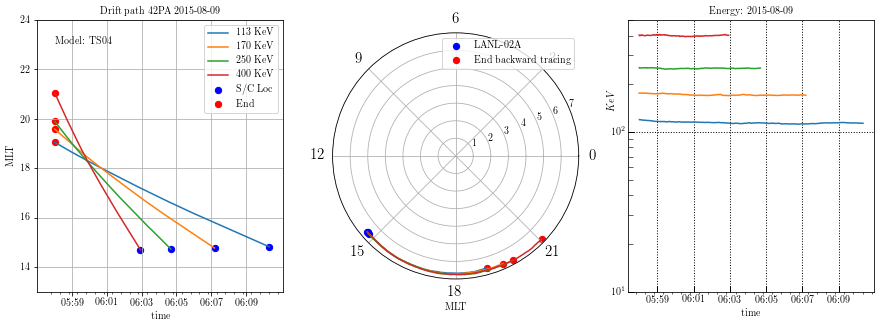

In [7]:
###########################################################
##### Visualize the data
###########################################################
datet = dt.datetime(2015,8,9)
date = dt.date(2015,8,9)
iyear = datet.year
dts = spt.Ticktock(datet)
iday = dts.DOY
%matplotlib inline
minuts = mdates.MinuteLocator(interval=2)  # every min
secticks = mdates.SecondLocator(interval=30)  # every sec
Fmt = mdates.DateFormatter('%H:%M')
#plt.style.use('classic')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
# Create a new figure
fig = plt.figure("pyplot_fig",figsize=(15,5))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,polar=True)
ax3 = plt.subplot(133)
ekev0 = LANL_02A_Ech   ### Change this for other LANL, i.e LANL-02A
xstart = np.zeros(len(ekev0))
ystart = np.zeros(len(ekev0))
xend = np.zeros(len(ekev0))
yend = np.zeros(len(ekev0))
rad_start = np.zeros(len(ekev0))
ro_start = np.zeros(len(ekev0))
rad_end = np.zeros(len(ekev0))
ro_end = np.zeros(len(ekev0))
ii=0
xstart = []
xend = []
model = ['Dipole', 'T96', 'T01', 'TS04']
for i in ekev0:
    #First subplot
    #plt.subplot(131)
    nt=len(tsec[ii])
    t_utc = np.zeros(len(tsec[ii]))
    for j in range(len(tsec[ii])):
        t_utc[j] = (tsec[ii][j]-datet).total_seconds()/60
    #ax1.plot(df.tsec, df.mlto,label=str(i))
    #ax1.plot(t_utc, mlto[ii][0:nt],label=str(i))
    ax1.plot(tsec[ii], mlto[ii][0:nt],label=str(i)+' KeV')
    #xstart[ii]=t_utc[0]
    xstart.append(tsec[ii][0])
    ystart[ii]=mlto[ii][0]
    #xend[ii]=t_utc[-1]
    xend.append(tsec[ii][-1])
    yend[ii]=mlto[ii][nt-1]
    #Second subplot
    #plt.subplot(132,polar=True)
    rad = np.ones(nt)
    for j in range(nt):
        rad[j] = np.pi*mlto[ii][j]/12
    print, rad
    ax2.plot(rad, ro[ii][0:nt])
    rad_start[ii] = rad[0]
    ro_start[ii] = ro[ii][0]
    rad_end[ii] = rad[nt-1]
    ro_end[ii] = ro[ii][nt-1]
    #ax2.scatter(rad[0],ro[ii][0],color='b',s=40,label='LANL-02A') # Change this for other LANL
    #ax2.text(rad[0]+0.1, df.ro[0], 'Start', fontsize=15, color='k')
    #ax2.scatter(rad[nt-1],ro[ii][nt-1],color='r',s=40,label='End backward tracing')
    #ax2.text(rad[-1]-0.1, df['ro'].iloc[-1]-0.1, 'End', fontsize=15, color='k')
    #Energy subplot
    ax3.plot(tsec[ii], Eo[ii][0:nt])
    ii=ii+1
# Plot Start and End points
ax1.scatter(xstart,ystart,color='b',s=40,label='S/C Loc')
ax1.scatter(xend,yend,color='r',s=40,label='End')
ax1.set_ylabel('MLT')
ax1.set_xlabel('time')
ax1.set_title('Drift path '+str(PA)+'PA '+ date.isoformat(),fontsize = 10)
ax1.set_xlim(xmin=dmin - timedelta(minutes=1))
ax1.set_ylim(ymin=13,ymax=24)
ax1.legend(loc=1,scatterpoints=1)
ax1.grid(b=True)
ax1.text(dmin, 23, 'Model: '+ model[imod], fontsize=10)
# format the ticks
ax1.xaxis.set_major_locator(minuts)
ax1.xaxis.set_major_formatter(Fmt)
ax1.xaxis.set_minor_locator(secticks)
#Second subplot
ax2.scatter(rad_start,ro_start,color='b',s=40,label='LANL-02A') # Change this for other LANL
ax2.scatter(rad_end,ro_end,color='r',s=40,label='End backward tracing')
ax2.axis([0, 2*np.pi, 0, 7])
ax2.set_xticklabels(['0','3','6','9','12','15','18','21'],fontsize = 15)
ax2.set_xlabel('MLT');
ax2.legend(loc=0,scatterpoints=1)
#Energy subplot
ax3.set_yscale("log", nonposy='clip')
ax3.set_ylim(ymin=10,ymax=500)
ax3.set_ylabel(r'$KeV$')
ax3.yaxis.set_label_coords(-0.05,0.7)
ax3.set_xlabel('time')
ax3.set_title('Energy: '+date.isoformat(),fontsize = 10);
ax3.grid(b='True',color='k', linestyle=':', linewidth=1)
ax3.tick_params(direction='in', length=6, width=1, colors='k')
ax3.tick_params(axis='y',which='minor',direction='in', length=5, width=0.6, colors='k')
ax3.xaxis.set_major_locator(minuts)
ax3.xaxis.set_major_formatter(Fmt)
ax3.xaxis.set_minor_locator(secticks)
#plt.grid(b='off') #No grid

#text(8.57, 0, r'\textbf{1}', fontsize=25, color='w')

### Saving picture
fig.savefig('LANL-02A_'+'inj'+str(PA)+'PAdegrees_'+model[imod]+'.png', dpi = 200) # Change this name for every injection

# # LANL-04A

In [12]:
# Input parameters
# 1- Date and time of the injection
#-----------------------------------------------------------------------------------#
imod = 3        # magnetic field model: 0=dipole, 1=T96_01, 2=T01_01, 3=T04_s
ipot = 1        # electric field model: 1=Weimer, 2=CIMI 
itrace = -1      # 1=forward, -1=backward tracing
ion= 1          # 1=ion, -1=electron
tf =1
dmin=dt.datetime(2015,8,9,5,58,0)
sim_dt = np.zeros(len(LANL_04A_Ech))
for i in range(len(LANL_04A_Ech)):
    sim_dt[i] = (LANL_04A_t[i]-dmin).total_seconds() # simulation time in seconds
LANL_04A_gsm.ticks = spt.Ticktock(LANL_04A_t, 'ISO') #
LANL_04A_sm = LANL_04A_gsm.convert('SM', 'car') # SM coordinates
PA = 40
sinA_loc = np.sin(PA/180*np.pi)
### Define class

part=testpartpy.avedrift(date,itrace=itrace,imod=imod,tf=1)
tsec = []
mlto = []
ro = []
Eo = []
for i in range(len(LANL_04A_Ech)):
    tsecarr,mltoarr,roarr,Eoarr,pa,istep = part.trace_drift_shell(LANL_04A_sm[i].data[0],\
                                        LANL_04A_t[i],LANL_04A_Ech[i],sinA_loc,sim_dt[i])
    tsec.append(tsecarr)
    mlto.append(mltoarr)
    ro.append(roarr)
    Eo.append(Eoarr)

Variable OriginFile appears to be non-record varying, skipping interpolation


/Users/gfarinas/anaconda3/envs/spacepy_env/lib/python3.6/site-packages/spacepy/datamodel.py:1468: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)


Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 3 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     mlto     ekeV    PA   Vsw   Pdyn
2015-08-09T06:16:50      -6     6.521    10.565      6.619 10.557   170.0  39.99
2015-08-09T06:16:45.344068      -6     6.524    10.598      6.622 10.589   170.0  39.99  508.76 2.7967
Variable OriginFile appears to be non-record varying, skipping interpolation


/Users/gfarinas/Documents/python_pack/test-particle/testpartpy.py:643: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(istep,dstep)==0:


2015-08-09T06:16:40.779747      -6     6.523    10.632      6.620 10.624   170.0  40.01  508.61 2.7951
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:16:36.286028      -6     6.518    10.665      6.616 10.658   170.0  40.03  508.46 2.7936
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:16:31.794880      -6     6.521    10.698      6.618 10.692   170.0  40.03  508.31 2.7921
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:16:27.321766      -6     6.513    10.732      6.612 10.727   170.6  40.00  508.17 2.7906
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:16:22.862310      -6     6.513    10.765      6.612 10.761   170.6  39.99  508.02 2.7891
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:16:18.318858      -6     6.514    10.798      6.613 10.795   170.4  40.03  507.88 2.78

2015-08-09T06:13:14.553769      -6     6.423    12.164      6.570 12.190   173.1  39.83  505.91 2.7667
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:13:10.133337      -6     6.423    12.198      6.573 12.224   173.0  39.82  505.94 2.7670
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:13:05.611752      -6     6.423    12.231      6.573 12.258   172.7  39.85  505.97 2.7673
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:13:01.127688      -6     6.419    12.264      6.572 12.291   173.2  39.78  506.00 2.7676
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:12:56.646621      -6     6.411    12.298      6.566 12.325   173.4  39.77  506.03 2.7679
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:12:52.191333      -6     6.408    12.331      6.565 12.359   173.4  39.76  506.06 2.76

2015-08-09T06:09:48.103148      -6     6.343    13.697      6.609 13.746   171.9  38.85  507.35 2.7802
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:43.816155      -6     6.338    13.730      6.607 13.780   171.9  38.82  507.38 2.7804
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:39.529713      -6     6.333    13.763      6.607 13.814   172.1  38.76  507.41 2.7805
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:34.916964      -6     6.328    13.797      6.607 13.848   172.3  38.71  507.44 2.7807
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:30.539338      -6     6.314    13.830      6.598 13.882   172.8  38.65  507.48 2.7808
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:26.125944      -6     6.315    13.863      6.602 13.916   172.3  38.66  507.51 2.78

2015-08-09T06:06:28.609006      -7     6.163    15.229      6.658 15.303   172.0  36.69  508.75 2.7869
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:24.349847      -7     6.163    15.262      6.665 15.337   171.4  36.68  508.78 2.7870
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:20.079510      -7     6.166    15.295      6.674 15.370   170.5  36.70  508.81 2.7872
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:15.772364      -7     6.162    15.329      6.676 15.404   170.9  36.60  508.84 2.7873
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:11.545659      -7     6.157    15.362      6.676 15.437   171.1  36.52  508.87 2.7875
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:06:07.243915      -7     6.153    15.395      6.679 15.471   171.0  36.46  508.90 2.78

2015-08-09T06:03:22.938885      -7     5.935    16.761      6.715 16.840   172.1  34.05  510.05 2.7962
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:19.072369      -7     5.930    16.794      6.716 16.873   171.7  34.03  510.08 2.7965
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:15.339919      -7     5.920    16.827      6.710 16.906   172.7  33.89  510.11 2.7967
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:11.723055      -7     5.922    16.861      6.720 16.939   172.0  33.87  510.13 2.7970
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:08.180589      -7     5.915    16.894      6.719 16.973   172.0  33.83  510.16 2.7972
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:04.543554      -7     5.918    16.927      6.730 17.006   171.2  33.80  510.18 2.79

2015-08-09T06:00:35.587133      -8     5.685    18.292      6.717 18.364   176.0  31.27  511.23 2.8074
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:32.251754      -8     5.680    18.326      6.717 18.397   175.8  31.25  511.25 2.8076
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:28.973732      -8     5.678    18.359      6.721 18.430   175.9  31.17  511.27 2.8078
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:25.626143      -8     5.676    18.392      6.726 18.463   175.6  31.13  511.30 2.8081
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:22.267546      -8     5.669    18.425      6.723 18.496   175.9  31.07  511.32 2.8083
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:19.041774      -8     5.667    18.459      6.727 18.529   175.8  31.00  511.34 2.80

2015-08-09T05:58:08.513764      -8     5.525    19.824      6.769 19.876   176.6  28.89  510.89 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:05.505924      -8     5.514    19.858      6.753 19.908   176.9  28.91  510.87 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:02.519155      -8     5.507    19.891      6.744 19.941   177.7  28.84  510.85 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:02.519155      -8     5.507    19.891      6.744 19.941   178.6  28.77  510.83 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
Variable OriginFile appears to be non-record varying, skipping interpolation
Info: the first line show Ro local and mlt local, i.e at the pos of the S/C and not at the equator
2015 221 3 1 1 1.00 ! iyear,iday,imod,ipot,ion,tf
  tsec             Dst    Lshell    mlti       ro     

2015-08-09T06:09:55.089665      -6     6.460    11.841      6.590 11.864   251.5  40.22  507.31 2.7801
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:52.064517      -6     6.456    11.874      6.587 11.898   252.1  40.18  507.33 2.7802
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:49.007191      -6     6.447    11.908      6.582 11.932   252.3  40.18  507.36 2.7803
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:46.047873      -6     6.446    11.941      6.582 11.966   252.7  40.14  507.38 2.7804
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:42.957040      -6     6.450    11.974      6.587 12.000   252.2  40.15  507.40 2.7805
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:09:39.953268      -6     6.446    12.008      6.585 12.034   252.4  40.13  507.42 2.78

2015-08-09T06:07:34.066957      -6     6.396    13.374      6.636 13.422   249.2  39.40  508.30 2.7848
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:30.964208      -6     6.397    13.407      6.640 13.456   248.8  39.39  508.32 2.7849
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:28.000364      -6     6.392    13.440      6.639 13.490   248.9  39.36  508.34 2.7850
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:24.953609      -7     6.392    13.474      6.643 13.524   248.3  39.37  508.36 2.7851
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:21.916907      -7     6.393    13.507      6.646 13.558   248.0  39.35  508.39 2.7852
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:18.869929      -7     6.388    13.540      6.646 13.591   248.0  39.32  508.41 2.78

2015-08-09T06:05:15.339820      -7     6.243    14.906      6.694 14.978   247.6  37.52  509.27 2.7894
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:12.337866      -7     6.243    14.939      6.699 15.012   247.6  37.45  509.29 2.7895
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:09.430818      -7     6.240    14.973      6.702 15.046   247.1  37.43  509.31 2.7896
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:06.497264      -7     6.233    15.006      6.703 15.079   247.3  37.37  509.33 2.7897
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:03.481495      -7     6.231    15.039      6.707 15.113   247.0  37.33  509.35 2.7898
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:00.516401      -7     6.227    15.073      6.708 15.147   247.1  37.26  509.38 2.78

2015-08-09T06:03:03.258443      -7     6.049    16.438      6.782 16.517   245.5  34.96  510.20 2.7976
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:00.606246      -7     6.040    16.472      6.779 16.551   246.4  34.85  510.22 2.7978
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:57.908015      -7     6.038    16.505      6.785 16.584   245.1  34.88  510.24 2.7980
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:55.263817      -7     6.026    16.538      6.778 16.617   245.7  34.80  510.25 2.7981
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:52.679677      -7     6.017    16.571      6.774 16.650   246.6  34.69  510.27 2.7983
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:50.065584      -7     6.010    16.605      6.772 16.684   246.8  34.63  510.29 2.79

2015-08-09T06:01:03.525280      -8     5.803    17.970      6.824 18.043   247.8  32.11  511.04 2.8056
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:01.087449      -8     5.788    18.003      6.808 18.076   248.7  32.08  511.06 2.8058
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:58.668749      -8     5.780    18.036      6.805 18.110   249.6  31.97  511.07 2.8059
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:56.269248      -8     5.778    18.070      6.811 18.143   248.6  31.97  511.09 2.8061
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:53.800267      -8     5.774    18.103      6.813 18.176   248.9  31.88  511.11 2.8062
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:51.417650      -8     5.762    18.136      6.802 18.209   249.9  31.81  511.12 2.80

2015-08-09T05:59:18.094971      -8     5.584    19.502      6.817 19.559   253.3  29.55  511.27 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:15.924911      -8     5.582    19.535      6.821 19.592   252.4  29.55  511.26 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:13.714254      -8     5.576    19.568      6.816 19.625   253.3  29.47  511.25 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:11.567388      -8     5.580    19.602      6.829 19.658   253.2  29.37  511.24 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:09.388914      -8     5.572    19.635      6.821 19.690   253.7  29.34  511.23 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:07.240292      -8     5.573    19.668      6.830 19.723   252.8  29.30  511.21 2.81

2015-08-09T06:08:48.674644      -6     6.495    10.623      6.611 10.631   401.4  40.03  507.79 2.7823
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:08:46.804479      -6     6.496    10.657      6.612 10.665   400.5  40.10  507.80 2.7824
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:08:44.974561      -6     6.485    10.690      6.602 10.699   401.8  40.09  507.81 2.7824
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:08:43.120352      -6     6.487    10.723      6.604 10.732   401.7  40.09  507.83 2.7825
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:08:41.196576      -6     6.477    10.756      6.596 10.766   404.1  40.01  507.84 2.7826
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:08:39.332606      -6     6.477    10.790      6.595 10.800   403.5  40.06  507.85 2.78

2015-08-09T06:07:22.823569      -7     6.412    12.156      6.571 12.188   406.9  39.97  508.39 2.7852
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:20.962646      -7     6.410    12.189      6.571 12.222   406.4  39.99  508.40 2.7852
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:19.092988      -7     6.406    12.223      6.569 12.256   406.1  40.01  508.41 2.7853
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:17.170683      -7     6.403    12.256      6.568 12.290   407.2  39.94  508.43 2.7854
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:15.279886      -7     6.406    12.289      6.572 12.324   405.9  39.98  508.44 2.7854
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:07:13.389547      -7     6.405    12.322      6.572 12.357   406.3  39.94  508.45 2.78

2015-08-09T06:05:57.835479      -7     6.293    13.688      6.581 13.744   409.0  38.82  508.98 2.7880
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:56.009690      -7     6.278    13.722      6.571 13.778   410.3  38.77  509.00 2.7881
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:54.198978      -7     6.276    13.755      6.573 13.812   409.5  38.77  509.01 2.7881
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:52.307340      -7     6.274    13.788      6.574 13.846   409.9  38.71  509.02 2.7882
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:50.464226      -7     6.275    13.821      6.579 13.879   409.4  38.68  509.03 2.7883
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:05:48.592398      -7     6.286    13.855      6.593 13.913   406.4  38.74  509.05 2.78

2015-08-09T06:04:34.578943      -7     6.147    15.220      6.649 15.296   404.9  36.86  509.57 2.7916
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:32.780550      -7     6.145    15.253      6.653 15.329   404.6  36.81  509.58 2.7917
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:31.050915      -7     6.139    15.287      6.652 15.363   404.2  36.79  509.59 2.7918
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:29.259887      -7     6.138    15.320      6.657 15.396   404.6  36.69  509.60 2.7919
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:27.540815      -7     6.132    15.353      6.657 15.430   404.4  36.66  509.62 2.7920
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:04:25.811853      -7     6.130    15.387      6.660 15.463   403.2  36.65  509.63 2.79

2015-08-09T06:03:16.439466      -7     5.946    16.752      6.728 16.831   401.7  34.29  510.11 2.7968
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:14.867998      -7     5.937    16.786      6.724 16.865   402.8  34.21  510.12 2.7969
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:13.250909      -7     5.934    16.819      6.728 16.898   401.2  34.21  510.14 2.7970
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:11.726628      -7     5.922    16.852      6.720 16.931   403.1  34.11  510.15 2.7971
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:10.102487      -7     5.921    16.885      6.726 16.964   402.3  34.06  510.16 2.7972
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:03:08.561111      -7     5.912    16.919      6.722 16.997   402.5  34.02  510.17 2.79

2015-08-09T06:02:04.173675      -8     5.766    18.284      6.850 18.354   394.7  31.61  510.62 2.8016
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:02.676608      -8     5.759    18.317      6.847 18.387   394.8  31.57  510.63 2.8017
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:02:01.154576      -8     5.750    18.351      6.842 18.420   395.6  31.51  510.64 2.8018
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:59.674898      -8     5.746    18.384      6.843 18.453   395.4  31.47  510.65 2.8019
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:58.190854      -8     5.745    18.417      6.850 18.486   395.1  31.39  510.66 2.8020
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:01:56.678447      -8     5.741    18.451      6.852 18.519   395.1  31.33  510.67 2.80

2015-08-09T06:00:58.071658      -8     5.592    19.817      6.896 19.868   397.8  29.08  511.08 2.8060
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:56.693482      -8     5.586    19.850      6.891 19.901   397.4  29.08  511.09 2.8061
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:55.303647      -8     5.581    19.883      6.889 19.934   398.5  29.00  511.10 2.8062
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:53.960785      -8     5.577    19.916      6.885 19.966   398.5  28.98  511.11 2.8063
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:52.675600      -8     5.576    19.950      6.890 19.999   398.4  28.92  511.12 2.8064
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T06:00:51.327727      -8     5.577    19.983      6.899 20.032   397.5  28.86  511.13 2.80

2015-08-09T05:59:58.866093      -8     5.478    21.349      6.860 21.380   408.2  27.18  511.50 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:57.643467      -8     5.478    21.382      6.864 21.413   407.6  27.15  511.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:56.432823      -8     5.477    21.415      6.863 21.446   407.0  27.15  511.49 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:55.267306      -8     5.472    21.449      6.855 21.479   409.6  27.07  511.48 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:54.057286      -8     5.473    21.482      6.859 21.512   407.1  27.11  511.47 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:52.871121      -8     5.474    21.515      6.862 21.545   408.4  27.02  511.47 2.81

2015-08-09T05:59:04.165213      -8     5.529    22.881      6.981 22.905   395.9  25.95  511.19 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:02.970443      -8     5.534    22.914      6.989 22.938   394.4  25.95  511.18 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:01.796346      -8     5.536    22.948      6.992 22.971   394.4  25.92  511.18 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:59:00.613507      -8     5.537    22.981      6.991 23.005   395.4  25.88  511.17 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:59.440753      -8     5.542    23.014      7.002 23.038   393.2  25.88  511.16 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:58.242052      -8     5.541    23.048      6.998 23.072   393.7  25.87  511.16 2.81

2015-08-09T05:58:09.699521      -8     5.622     0.414      7.057  0.441   388.1  25.70  510.88 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:08.495613      -8     5.617     0.447      7.040  0.474   390.1  25.75  510.87 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:07.328021      -8     5.618     0.481      7.039  0.508   389.4  25.79  510.87 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:06.158629      -8     5.621     0.514      7.041  0.541   389.8  25.78  510.86 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:04.996024      -8     5.625     0.547      7.048  0.574   389.0  25.77  510.85 2.8100
Variable OriginFile appears to be non-record varying, skipping interpolation
2015-08-09T05:58:03.806280      -8     5.630     0.581      7.055  0.608   387.5  25.79  510.85 2.81

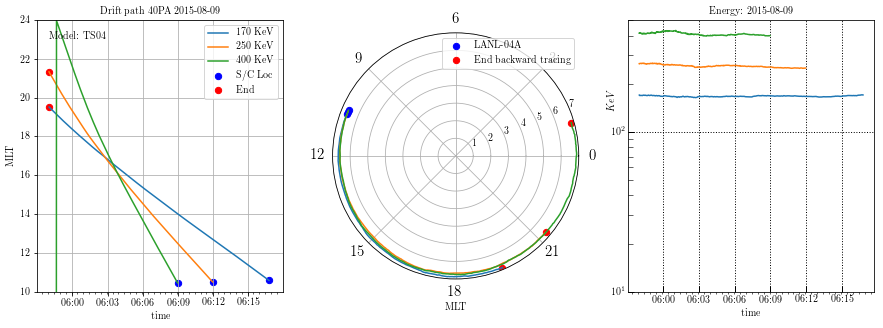

In [7]:
###########################################################
##### Visualize the data
###########################################################
datet = dt.datetime(2015,8,9)
date = dt.date(2015,8,9)
iyear = datet.year
dts = spt.Ticktock(datet)
iday = dts.DOY
%matplotlib inline
minuts = mdates.MinuteLocator(interval=3)  # every min
secticks = mdates.SecondLocator(interval=30)  # every sec
Fmt = mdates.DateFormatter('%H:%M')
#plt.style.use('classic')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
# Create a new figure
fig = plt.figure("pyplot_fig",figsize=(15,5))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,polar=True)
ax3 = plt.subplot(133)
ekev0 = LANL_04A_Ech   ### Change this for other LANL, i.e LANL-02A
xstart = np.zeros(len(ekev0))
ystart = np.zeros(len(ekev0))
xend = np.zeros(len(ekev0))
yend = np.zeros(len(ekev0))
rad_start = np.zeros(len(ekev0))
ro_start = np.zeros(len(ekev0))
rad_end = np.zeros(len(ekev0))
ro_end = np.zeros(len(ekev0))
ii=0
xstart = []
xend = []
model = ['Dipole', 'T96_01', 'T01_01', 'TS04']
for i in ekev0:
    #First subplot
    #plt.subplot(131)
    nt=len(tsec[ii])
    t_utc = np.zeros(len(tsec[ii]))
    for j in range(len(tsec[ii])):
        t_utc[j] = (tsec[ii][j]-datet).total_seconds()/60
    #ax1.plot(df.tsec, df.mlto,label=str(i))
    #ax1.plot(t_utc, mlto[ii][0:nt],label=str(i))
    ax1.plot(tsec[ii], mlto[ii][0:nt],label=str(i)+' KeV')
    #xstart[ii]=t_utc[0]
    xstart.append(tsec[ii][0])
    ystart[ii]=mlto[ii][0]
    #xend[ii]=t_utc[-1]
    xend.append(tsec[ii][-1])
    yend[ii]=mlto[ii][nt-1]
    #Second subplot
    #plt.subplot(132,polar=True)
    rad = np.ones(nt)
    for j in range(nt):
        rad[j] = np.pi*mlto[ii][j]/12
    print, rad
    ax2.plot(rad, ro[ii][0:nt])
    rad_start[ii] = rad[0]
    ro_start[ii] = ro[ii][0]
    rad_end[ii] = rad[nt-1]
    ro_end[ii] = ro[ii][nt-1]
    #ax2.scatter(rad[0],ro[ii][0],color='b',s=40,label='LANL-02A') # Change this for other LANL
    #ax2.text(rad[0]+0.1, df.ro[0], 'Start', fontsize=15, color='k')
    #ax2.scatter(rad[nt-1],ro[ii][nt-1],color='r',s=40,label='End backward tracing')
    #ax2.text(rad[-1]-0.1, df['ro'].iloc[-1]-0.1, 'End', fontsize=15, color='k')
    #Energy subplot
    ax3.plot(tsec[ii], Eo[ii][0:nt])
    ii=ii+1
# Plot Start and End points
ax1.scatter(xstart,ystart,color='b',s=40,label='S/C Loc')
ax1.scatter(xend,yend,color='r',s=40,label='End')
ax1.set_ylabel('MLT')
ax1.set_xlabel('time')
ax1.set_title('Drift path '+str(PA)+'PA  '+' '+ date.isoformat(),fontsize = 10)
ax1.set_xlim(xmin=dmin - timedelta(minutes=1))
ax1.set_ylim(ymin=10,ymax=24)
ax1.legend(loc=1,scatterpoints=1)
ax1.grid(b=True)
ax1.text(dmin, 23, 'Model: '+ model[imod], fontsize=10)
# format the ticks
ax1.xaxis.set_major_locator(minuts)
ax1.xaxis.set_major_formatter(Fmt)
ax1.xaxis.set_minor_locator(secticks)
#Second subplot
ax2.scatter(rad_start,ro_start,color='b',s=40,label='LANL-04A') # Change this for other LANL
ax2.scatter(rad_end,ro_end,color='r',s=40,label='End backward tracing')
ax2.axis([0, 2*np.pi, 0, 7])
ax2.set_xticklabels(['0','3','6','9','12','15','18','21'],fontsize = 15)
ax2.set_xlabel('MLT');
ax2.legend(loc=0,scatterpoints=1)
#Energy subplot
ax3.set_yscale("log", nonposy='clip')
ax3.set_ylim(ymin=10,ymax=500)
ax3.set_ylabel(r'$KeV$')
ax3.yaxis.set_label_coords(-0.05,0.7)
ax3.set_xlabel('time')
ax3.set_title('Energy: '+date.isoformat(),fontsize = 10);
ax3.grid(b='True',color='k', linestyle=':', linewidth=1)
ax3.tick_params(direction='in', length=6, width=1, colors='k')
ax3.tick_params(axis='y',which='minor',direction='in', length=5, width=0.6, colors='k')
ax3.xaxis.set_major_locator(minuts)
ax3.xaxis.set_major_formatter(Fmt)
ax3.xaxis.set_minor_locator(secticks)
#plt.grid(b='off') #No grid

#text(8.57, 0, r'\textbf{1}', fontsize=25, color='w')

### Saving picture
fig.savefig('LANL-04A_'+'inj'+str(PA)+'PAdegrees_'+model[imod]+'.png', dpi = 200) # Change this name for every injection

In [ ]:
idx1 = np.argmin(abs((df[3]-5)))

In [ ]:
epoch=dt.datetime(1970,1,2)
epoch.isoformat()

In [ ]:
a = []

In [ ]:
a.append(epoch)
a

In [ ]:
a[3].isoformat()

In [ ]:
a=dt.time(5,4,5)
a.isoformat()